In [25]:
import torch
import os
import time
import math
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from torch.autograd import grad
from torch.nn import Parameter
cuda = torch.cuda.is_available()
from google.colab import drive
import pickle as pk
from torchsummary import summary
# NN Architecture
## all layers that we want to use are in package nn and we can use as many layers as we want
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms


An autoencoder is a neural network that is trained to aim to copy its input to its output. Internally, it has a hidden layer that describes a code used to represent the input. The network may be viewed as consisting of two parts: an encoder function “h=f(x)” and a decoder that produces a reconstruction “r=g(h)”.

**Excercise 1.**

Autoencoder

Implement an Autoencoder that encodes the MNIST dataset to a latent dimension of sizem < 784. Use Tranposed Convolutions and/or Unpooling to solve this exercise. Train the Autoencoder and plot the reconstruction training loss. Plot 5 digits (of your choice) beforeand after reconstruction. Do this for two different latent dimension sizes.

In [3]:
# how many samples per batch to load
batch_size = 20

train_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size=len(train_data))

batch = next(iter(train_loader))
x, y = batch
mean, std = torch.mean(x), torch.std(x)

transform = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean, std)
])

train_data = datasets.MNIST('data', train=True, download=True, transform=transform)

test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw





Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Text(0.5, 1.0, '4')

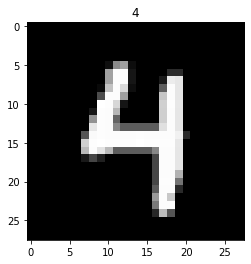

In [4]:
# Visualize the data to see if your data has loaded correctly or not.
# Obtaining one batch of training images
# Then getting one image from the batch

import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

plt.imshow(images[0].reshape([28, 28]), cmap='gray')
plt.title(labels[0].item())

Images of the MNIST dataset are of dimension 28 * 28 so, we’ll train the autoencoder with these images by flattening them into 784 (i.e. 28*28 = 784) length vectors. Also, the images from this dataset are already normalized such that the values are between 0 and 1.

**Model architecture:** 


ENCODER: The encoder will be made of one linear layer where the depth dimensions should change as follows: 784 inputs — > encoding_dim.

Latent dimension is a intermediate dimension between input & output which can be manipulated as per your need but its size must stay between input & output dimensions.

In [ ]:
# define the NN architecture
class AutoencoderLinear(nn.Module):
    def __init__(self, encoding_dim):
        super(AutoencoderLinear, self).__init__()
        ## encoder ##
        # linear layer (784 -> encoding_dim)
        self.fc1 = nn.Linear(28 * 28, encoding_dim)
        self.convTrans1 = nn.ConvTranspose2d(28*28, encoding_dim, kernel_size=3)
        
        ## decoder ##
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(encoding_dim, 28*28)
        self.convTrans2 = nn.ConvTranspose2d(encoding_dim, encoding_dim, kernel_size=3)
       

    def forward(self, x):
        # add layer, with relu activation function
        x = f.relu(self.fc1(x))
        #x = self.convTrans1(x)
        # output layer (sigmoid for scaling from 0 to 1)
        #x = self.convTrans2(x)
        x = torch.sigmoid(self.fc2(x))
                

        return x

# initialize the NN
encoding_dim = 32
model = AutoencoderLinear(encoding_dim)
print(model)

AutoencoderLinear(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (convTrans1): ConvTranspose2d(784, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc2): Linear(in_features=32, out_features=784, bias=True)
  (convTrans2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
)


In [ ]:
## TRAIN LINEAR AUTOENCODER

# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 10.700501
Epoch: 2 	Training Loss: 10.687055
Epoch: 3 	Training Loss: 10.682983
Epoch: 4 	Training Loss: 10.680930
Epoch: 5 	Training Loss: 10.676676


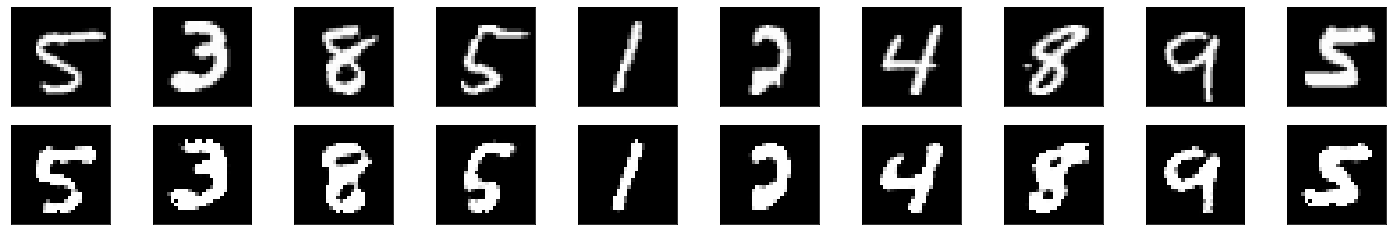

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


In [ ]:
# CONVOLUTIONAL AUTOENCODER

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        # conv layer (depth from 32 --> 64), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 1, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)


ConvAutoencoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [ ]:
# number of epochs to train the model
n_epochs = 5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 23.196707
Epoch: 2 	Training Loss: 23.196707
Epoch: 3 	Training Loss: 23.196707
Epoch: 4 	Training Loss: 23.196707
Epoch: 5 	Training Loss: 23.196707


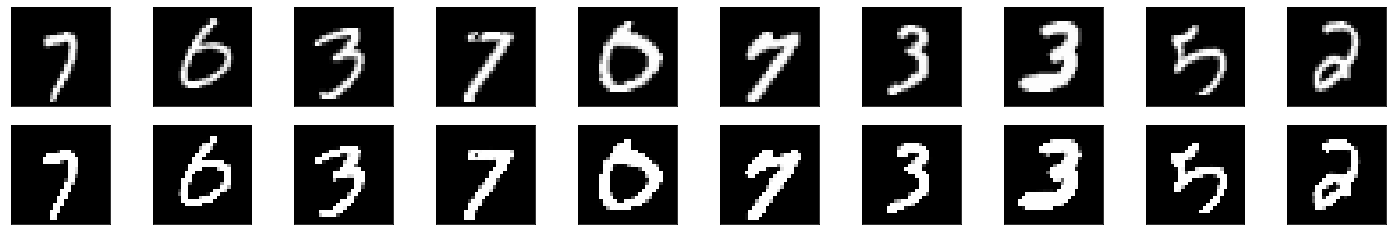

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


**Excercise 2.**
Variational Autoencoder

Now that you have built an Autoencoder, it is time to implement a Variational Autoencoder.You can use the Autoencoder you trained in the previous exercise and adapt it for this exercise. Do not forget to use the reparametrization trick for sampling from Z-space.(30%)(a) Train a Variational Autoencoder with latent dimension of size 2. Then, plot the digitswhere their associated position was in latent space similarly as explained in the lecture.(25%)(b) Plot the variance vector of the decoder for a single input as an image (in digit space;[3,28,28]). What is the interpretation of that?(25%)

In [78]:
# This generic form of the KL is called the monte-carlo approximation. 
# This means we sample z many times and estimate the KL divergence. 
# (in practice, these estimates are really good and with a batch size of 128 or more, the estimate is very accurate).

def kl_divergence(self, z, mu, std):
    # --------------------------
    # Monte carlo KL divergence
    # --------------------------
    # 1. define the first two probabilities (in this case Normal for both)
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)

    # 2. get the probabilities from the equation
    log_qzx = q.log_prob(z)
    log_pz = p.log_prob(z)

    # kl
    kl = (log_qzx - log_pz)
    
    # sum over last dim to go from single dim distribution to multi-dim
    kl = kl.sum(-1)
    return kl

**Defining the encoder**
As our inputs are images, it’s most reasonable to apply some convolutional transformations to them. What’s most noteworthy is the fact that we are creating two vectors in our encoder, as the encoder is supposed to create objects following a Gaussian Distribution:
A vector of means
A vector of standard deviations

In [29]:
# The loss function consists of two terms. Reconstruction loss, for which was used binary_cross_entropy, 
# in the paper was used mean squared error. And regularization loss or Kullback–Leibler divergence 
# that will force z to be a normal distribution with mean=0 and std=1.
def loss_criterion(inputs, targets, logvar, mu):
    # Reconstruction loss
    bce_loss = F.binary_cross_entropy(inputs, targets, reduction="sum")
    # Regularization term
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return bce_loss + kl_loss

In [30]:
# we have to devide previous ConvAutoencoder class into to separate functional units - encoder and decoder

# CONVOLUTIONAL AUTOENCODER : ENCODER, LATENT LAYER, DECODER

class ConvEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ConvEncoder, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        p_x = F.relu(self.fc1(x))
        p_x = F.relu(self.fc2(p_x))
        return p_x

class LatentZ(nn.Module):
    def __init__(self, hidden_size, latent_size):
        super(LatentZ, self).__init__()
        self.mu = nn.Linear(hidden_size, latent_size)
        self.logvar = nn.Linear(hidden_size, latent_size)

    def forward(self, p_x):
        mu = self.mu(p_x)
        logvar = self.logvar(p_x)

        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)

        return std * eps + mu, logvar, mu


class ConvDecoder(nn.Module):
    def __init__(self, latent_size, hidden_size, input_size):
        super().__init__()
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, input_size)

    def forward(self, z_x):
        q_x = F.relu(self.fc1(z_x))
        q_x = torch.sigmoid(self.fc2(q_x))
        return q_x

# ================================
######## Variational Autoencoder (VAE) to draw MNIST characters ##########

class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size=2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size

        self.encoder = ConvEncoder(input_size, hidden_size)
        self.latent_z = LatentZ(hidden_size, latent_size)
        self.decoder = ConvDecoder(latent_size, hidden_size, input_size)

    def forward(self, x):
        p_x = self.encoder(x)
        z, logvar, mu = self.latent_z(p_x)
        q_z = self.decoder(z)

        return q_z, logvar, mu, z

In [37]:
class Trainer:
    def __init__(self, model, data_loader, optimizer, device, callbacks=[]):
        self.model = model
        self.data_loader = data_loader
        self.optimizer = optimizer
        self.device = device
        self.callbacks = callbacks

    def run_train_loop(self, epochs):
        self.model.to(self.device)  # Set model params to cpu/gpu
        self.model.train()  # Set model to train mode

        losses = []
        for epoch in range(1, epochs+1):
            print("-" * 20)
            print("Epoch {}".format(epoch))

            running_loss = 0
            for inputs, _ in self.data_loader:
                self.optimizer.zero_grad()

                # Prepare inputs and targets
                x = inputs.view(inputs.size(0), -1).to(self.device)
                y = (x > 0.5).float().to(self.device)

                # Forward pass
                y_hat, logvar, mu, _ = self.model(x)

                # Compute loss
                loss = loss_criterion(y_hat, y, logvar, mu)

                # Compute gradients and update weights
                loss.backward()
                self.optimizer.step()

                running_loss += loss

            epoch_loss = running_loss / len(self.data_loader)
            losses.append(epoch_loss.item())
            print("Loss: {:.4f}".format(epoch_loss))

            # On end of epoch call any callbacks
            if self.callbacks:
                [fn(self) for fn in self.callbacks]

        return losses


In [59]:
# This block just repeats the loading of the data from above
# because after disconnection in Google Colab from GPU (every time when I close my Laptop for example)
# I had to scroll the whole file nd reload it. 

# Training params
batch_size = 64
lr = 0.001
device = "cuda"

# Model params
input_size = 784
hidden_size = 512
latent_size = 10

# Load data set
dataset = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

# Create data loader
data_loader = DataLoader(dataset=dataset, batch_size=batch_size)

# Initialize model
model = VAE(input_size, hidden_size, latent_size)

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Initialize trainer
trainer = Trainer(model=model,
                  data_loader=data_loader,
                  optimizer=optimizer,
                  device=device)

# print model structure
print(model)


VAE(
  (encoder): ConvEncoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
  )
  (latent_z): LatentZ(
    (mu): Linear(in_features=512, out_features=10, bias=True)
    (logvar): Linear(in_features=512, out_features=10, bias=True)
  )
  (decoder): ConvDecoder(
    (fc1): Linear(in_features=10, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [60]:
losses = trainer.run_train_loop(epochs=10)


--------------------
Epoch 1
Loss: 9334.0400
--------------------
Epoch 2
Loss: 7161.6836
--------------------
Epoch 3
Loss: 6821.5337
--------------------
Epoch 4
Loss: 6633.8164
--------------------
Epoch 5
Loss: 6523.2827
--------------------
Epoch 6
Loss: 6430.4272
--------------------
Epoch 7
Loss: 6355.0854
--------------------
Epoch 8
Loss: 6288.3506
--------------------
Epoch 9
Loss: 6238.8857
--------------------
Epoch 10
Loss: 6188.6636


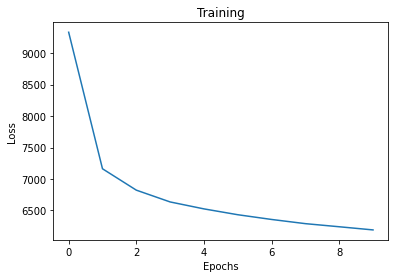

In [61]:
plt.plot(np.arange(len(losses)), losses)
plt.title("Training")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

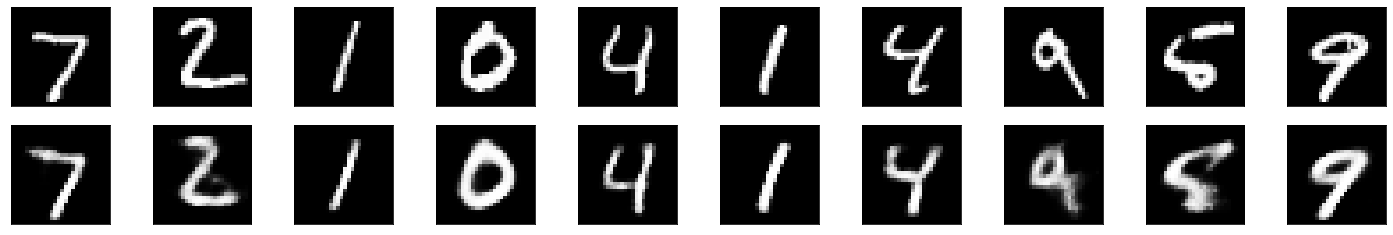

In [48]:
# Load data set
testset = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

# Create data loader
test_loader = DataLoader(dataset=testset, batch_size=batch_size)

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images = images.cuda()
labels = labels.cuda()

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.cpu().numpy()

# output is resized into a batch of images
output = output[0].view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)



In [55]:
# Finally repeat everything for 2D Laten Space

# Training params
batch_size = 64
lr = 0.001
device = "cuda"

# Model params
input_size = 784
hidden_size = 512
latent_size = 2

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Initialize trainer
trainer = Trainer(model=model,
                  data_loader=data_loader,
                  optimizer=optimizer,
                  device=device)

# Initialize model
model = VAE(input_size, hidden_size, latent_size)
model.cuda()

# new train phase
losses = trainer.run_train_loop(epochs=10)



--------------------
Epoch 1
Loss: 11318.6934
--------------------
Epoch 2
Loss: 10228.3740
--------------------
Epoch 3
Loss: 9973.1084
--------------------
Epoch 4
Loss: 9837.8428
--------------------
Epoch 5
Loss: 9724.4766
--------------------
Epoch 6
Loss: 9641.6826
--------------------
Epoch 7
Loss: 9557.0449
--------------------
Epoch 8
Loss: 9480.5840
--------------------
Epoch 9
Loss: 9437.9307
--------------------
Epoch 10
Loss: 9390.3682


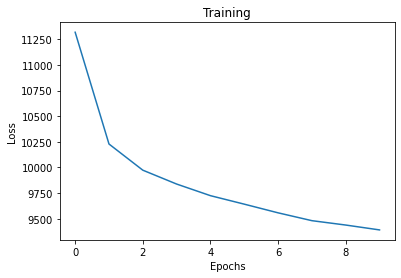

In [56]:
plt.plot(np.arange(len(losses)), losses)
plt.title("Training")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Load data set
testset = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

# Create data loader
test_loader = DataLoader(dataset=testset, batch_size=batch_size)

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images = images.cuda()
labels = labels.cuda()

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.cpu().numpy()

# output is resized into a batch of images
output = output[0].view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)